## Assignment: NYC taxi trip duration prediction

In this assignment, we are providing you the NYC-trip duration dataset. 

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. **To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied.** If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

You can download the dataset from the link given below and build a predictive model using that. Once you have built the model, submit the jupyter notebook and we will evaluate it.

**Independent Variables**

`id` - a unique identifier for each trip

`vendor_id` - a code indicating the provider associated with the trip record

`pickup_datetime` - date and time when the meter was engaged

`dropoff_datetime` - date and time when the meter was disengaged

`passenger_count` - the number of passengers in the vehicle (driver entered value)

`pickup_longitude` - the longitude where the meter was engaged

`pickup_latitude` - the latitude where the meter was engaged

`dropoff_longitude` - the longitude where the meter was disengaged

`dropoff_latitude` - the latitude where the meter was disengaged

`store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)


**Target Varible**

`trip_duration` -  Duration of the trip in seconds

## Outline to predict _'trip duration'_ of NYC taxi trip data
    
1. Import Libraries
2. Prepare Data
3. Segregate Data
    <br>3.1 Independent Variables
    <br>3.2 Dependent Variables
4. `Method 1: Linear Regression using Statsmodels`
    <br>4.1 Stats Model Summary
    <br>4.2 Explanation of OLS Parameters
5. `Method 2: Linear Regression using KFold CV and Check assumptions`
    <br>5.1 Create the independent and dependent variables.
    <br>5.2 Set the k-fold parameters mentioned above.
    <br>5.3 Create the linear regression model
    <br>5.4 Create the variable `results_kfold` to store the cross-validation scores for each split
    <br>5.5 Incorporate the `kfold` variable into the `cv` parameter.
    <br>5.6 Obtain the $R^2$ by taking the mean of the cross-validation scores from the regression.
    <br>5.7 Parameters of Linear Regression
    <br>5.8 Re-run Linear Regression (After removing highly correcly variables)
6. `Method 3: Ridge Regression`
    <br>6.1 Import Libraries
    <br>6.2 Create the independent and dependent variables
    <br>6.3 Create Ridge Regression and fit the model
    <br>6.4 Implement the model in given $\alpha$ range and plot
7. `Method 4: Lasso Regression`
    <br>6.1 Import Libraries
    <br>6.2 Create the independent and dependent variables
    <br>6.3 Create Lasso Regression and fit the model
    <br>6.4 Implement the model in given $\alpha$ range and plot


### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [2]:
# Install 'haversine' library. This helps to find distance between two locations having Lat & Lon values.

!pip install haversine

In [3]:
from haversine import haversine, Unit

In [4]:
# Read NYC Tax trip duration data from the CSV file that is available from the same directory of this notebook

nyc_taxi_trip_df = pd.read_csv('nyc_taxi_trip_duration.csv')
nyc_taxi_trip_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [5]:
nyc_taxi_trip_df.shape

(729322, 11)

In [6]:
nyc_taxi_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


### 2. Prepare Data 

In [7]:
# Calculate Distance betweeen Pickup and Dropoff Locations in miles
# Use haversine library function to compute the distance in Miles

def fn_compute_distance(row):
    """
    Function takes dataframe as input and computes the distance between
    Pickup and Dropoff location by using haversine functiona by passing 
    respective Pickup and Dropoff Latitude and Longitude
    
    Input: Dataframe
    Output: Distance in Miles
    """
    
    pickup_loc = (row['pickup_latitude'], row['pickup_longitude'])
    drop_loc   = (row['dropoff_latitude'], row['dropoff_longitude'])
    
    return haversine(pickup_loc, drop_loc, unit=Unit.MILES)

In [8]:
# Create new column 'distance_in_mile' by calliing 'fn_compute_distance' iteratively through entire dataframe

nyc_taxi_trip_df['distance_in_mile'] = nyc_taxi_trip_df.apply(lambda row: fn_compute_distance(row), axis = 1)

In [9]:
# Create a new column 'distance_range' based on 'distance_in_mile' to group distance

nyc_taxi_trip_df['distance_range'] = nyc_taxi_trip_df['distance_in_mile'].apply(
    lambda x: 3 if x >= 350 else (2 if x >= 150 else (1 if x >= 50 else 0)))
nyc_taxi_trip_df['distance_range'] = nyc_taxi_trip_df['distance_range'].astype('int64')

# Convert into Integer type

nyc_taxi_trip_df['vendor_id'] = nyc_taxi_trip_df['vendor_id'].astype('int64')

In [10]:
nyc_taxi_trip_df['store_and_fwd_flag']  = nyc_taxi_trip_df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
nyc_taxi_trip_df['store_and_fwd_flag']  = nyc_taxi_trip_df['store_and_fwd_flag'].astype('int64')

In [11]:
nyc_taxi_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  int64  
 10  trip_duration       729322 non-null  int64  
 11  distance_in_mile    729322 non-null  float64
 12  distance_range      729322 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 72.3+ MB


In [12]:
# Find any null values in the NYC dataframe

nyc_taxi_trip_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
distance_in_mile      0
distance_range        0
dtype: int64

In [13]:
# Modify "Pick Up and Dropoff Datetime" into useful Day, Week, Month and Year features

nyc_taxi_trip_df['pickup_datetime']   = pd.to_datetime(nyc_taxi_trip_df['pickup_datetime'], format= '%Y-%m-%d %H:%M:%S')
nyc_taxi_trip_df['dropoff_datetime']  = pd.to_datetime(nyc_taxi_trip_df['dropoff_datetime'], format= '%Y-%m-%d %H:%M:%S')
     
# Day of year
nyc_taxi_trip_df['doy_of_pickup']      = nyc_taxi_trip_df['pickup_datetime'].dt.dayofyear
nyc_taxi_trip_df['doy_of_dropoff']     = nyc_taxi_trip_df['dropoff_datetime'].dt.dayofyear

# Day of week
nyc_taxi_trip_df['dow_of_pickup']      = nyc_taxi_trip_df["pickup_datetime"].dt.dayofweek
nyc_taxi_trip_df['dow_of_dropoff']     = nyc_taxi_trip_df["dropoff_datetime"].dt.dayofweek

# Name of day 
nyc_taxi_trip_df['day_of_pickup']      = nyc_taxi_trip_df["pickup_datetime"].dt.day_name()
nyc_taxi_trip_df['day_of_dropoff']     = nyc_taxi_trip_df["dropoff_datetime"].dt.day_name()

# week of year
nyc_taxi_trip_df['woy_of_pickup']      = nyc_taxi_trip_df['pickup_datetime'].dt.isocalendar().week
nyc_taxi_trip_df['woy_of_dropoff']     = nyc_taxi_trip_df['dropoff_datetime'].dt.isocalendar().week

nyc_taxi_trip_df['is_pickup_weekday']  = nyc_taxi_trip_df['day_of_pickup'].map({'Monday': 1, 'Tuesday': 1, 'Wednesday': 1, 'Thursday': 1, 'Friday': 1, 'Saturday':0, 'Sunday': 0})
nyc_taxi_trip_df['is_dropoff_weekday'] = nyc_taxi_trip_df['day_of_dropoff'].map({'Monday': 1, 'Tuesday': 1, 'Wednesday': 1, 'Thursday': 1,'Friday': 1, 'Saturday':0, 'Sunday': 0})

# month of year 
nyc_taxi_trip_df['moy_of_pickup']      = nyc_taxi_trip_df['pickup_datetime'].dt.month
nyc_taxi_trip_df['moy_of_dropoff']     = nyc_taxi_trip_df['dropoff_datetime'].dt.month

# day of week when last transaction was done isoweekday()
nyc_taxi_trip_df['dow_of_pickup']      = nyc_taxi_trip_df['pickup_datetime'].dt.isocalendar().day
nyc_taxi_trip_df['dow_of_dropoff']     = nyc_taxi_trip_df['dropoff_datetime'].dt.isocalendar().day

In [14]:
# Using toordinal() to generate ordinal value.

nyc_taxi_trip_df['pickup_datetime']   = nyc_taxi_trip_df['pickup_datetime'].apply(lambda x: x.toordinal())
nyc_taxi_trip_df['dropoff_datetime']  = nyc_taxi_trip_df['dropoff_datetime'].apply(lambda x: x.toordinal())

In [15]:
nyc_taxi_trip_df.drop(['day_of_pickup', 'day_of_dropoff', 'id'], axis = 1, inplace = True)

In [16]:
nyc_taxi_trip_df.shape

(729322, 22)

In [17]:
nyc_taxi_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vendor_id           729322 non-null  int64  
 1   pickup_datetime     729322 non-null  int64  
 2   dropoff_datetime    729322 non-null  int64  
 3   passenger_count     729322 non-null  int64  
 4   pickup_longitude    729322 non-null  float64
 5   pickup_latitude     729322 non-null  float64
 6   dropoff_longitude   729322 non-null  float64
 7   dropoff_latitude    729322 non-null  float64
 8   store_and_fwd_flag  729322 non-null  int64  
 9   trip_duration       729322 non-null  int64  
 10  distance_in_mile    729322 non-null  float64
 11  distance_range      729322 non-null  int64  
 12  doy_of_pickup       729322 non-null  int32  
 13  doy_of_dropoff      729322 non-null  int32  
 14  dow_of_pickup       729322 non-null  UInt32 
 15  dow_of_dropoff      729322 non-nul

In [18]:
nyc_taxi_trip_df['dow_of_pickup']  = nyc_taxi_trip_df['dow_of_pickup'].astype('int64')
nyc_taxi_trip_df['dow_of_dropoff']  = nyc_taxi_trip_df['dow_of_dropoff'].astype('int64')
nyc_taxi_trip_df['woy_of_pickup']  = nyc_taxi_trip_df['woy_of_pickup'].astype('int64')
nyc_taxi_trip_df['woy_of_dropoff']  = nyc_taxi_trip_df['woy_of_dropoff'].astype('int64')

In [19]:
nyc_taxi_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vendor_id           729322 non-null  int64  
 1   pickup_datetime     729322 non-null  int64  
 2   dropoff_datetime    729322 non-null  int64  
 3   passenger_count     729322 non-null  int64  
 4   pickup_longitude    729322 non-null  float64
 5   pickup_latitude     729322 non-null  float64
 6   dropoff_longitude   729322 non-null  float64
 7   dropoff_latitude    729322 non-null  float64
 8   store_and_fwd_flag  729322 non-null  int64  
 9   trip_duration       729322 non-null  int64  
 10  distance_in_mile    729322 non-null  float64
 11  distance_range      729322 non-null  int64  
 12  doy_of_pickup       729322 non-null  int32  
 13  doy_of_dropoff      729322 non-null  int32  
 14  dow_of_pickup       729322 non-null  int64  
 15  dow_of_dropoff      729322 non-nul

### 3. Segregate into Independent and Dependent Variables

In [20]:
#seperating independent and dependent variables
    
X             = nyc_taxi_trip_df.drop(['trip_duration'], axis=1)
Y             = nyc_taxi_trip_df['trip_duration']

X_short_range = X[X['distance_range'] == 0]
X_distance_df = pd.DataFrame(nyc_taxi_trip_df['distance_in_mile'])
X_selected_df = X.drop(labels = ['dow_of_pickup', 'dow_of_dropoff', 'woy_of_pickup', 'woy_of_dropoff'], axis = 1)

cols          = X.columns
X.shape, X_short_range.shape, X_distance_df.shape, X_selected_df.shape, Y.shape

((729322, 21), (729306, 21), (729322, 1), (729322, 17), (729322,))

In [21]:
# Import relevant libraries to implement the linear model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold # K-fold Cross-Validation
from sklearn.model_selection import cross_val_score # Cross-Validation Score
from sklearn.metrics import r2_score # R-Squared
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.gofplots import qqplot

# from statsmodels.tools.eval_measures import rmse
# import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

### 4.  Method 1: Linear Regression using Statsmodels

In [121]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.compat import lzip
import statsmodels

X_c   = X.copy()
y_c   = Y.copy()

train_x_c, test_x_c, train_y_c, test_y_c = train_test_split(X_c, y_c, random_state = 101)
standard_scaler = StandardScaler()

# scaler = StandardScaler().set_output()
train_x_c = standard_scaler.fit_transform(train_x_c)
test_x_c = standard_scaler.transform(test_x_c)

In [122]:
train_x_c.shape, test_x_c.shape, train_y_c.shape, test_y_c.shape

((546991, 21), (182331, 21), (546991,), (182331,))

In [123]:
# first artificially add intercept to X

X_c_s = sm.add_constant(train_x_c)
slr_c = sm.OLS(train_y_c, train_x_c)
slr_model_c = slr_c.fit()

### 4.1. Stats Model Summary

In [124]:
slr_model_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          trip_duration   R-squared (uncentered):                   0.218
Model:                            OLS   Adj. R-squared (uncentered):              0.218
Method:                 Least Squares   F-statistic:                              7634.
Date:                Sat, 25 May 2024   Prob (F-statistic):                        0.00
Time:                        20:30:34   Log-Likelihood:                     -5.1379e+06
No. Observations:              546991   AIC:                                  1.028e+07
Df Residuals:                  546971   BIC:                                  1.028e+07
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            90.6477      4.112     22.046      0.000      82.589      98.707
x2          -9.87e+14   4.08e+12   -242.046      0.000   -9.95e+14   -9.79e+14
x3          8.577e+14   3.54e+12    242.046      0.000    8.51e+14    8.65e+14
x4            16.0424      4.101      3.912      0.000       8.005      24.080
x5             6.8228      7.067      0.965      0.334      -7.028      20.673
x6           -22.9905      4.663     -4.931      0.000     -32.129     -13.852
x7           -14.0099      6.989     -2.004      0.045     -27.709      -0.311
x8           -19.9449      4.619     -4.318      0.000     -28.999     -10.891
x9             5.6513      3.942      1.434      0.152      -2.075      13.378
x10          460.2920      4.554    101.085      0.000     451.367     469.217
x11         -176.8332      4.463    -39.626      0.000    -185.580    -168.087
x12          9.87e+14   4.08e+12    242.046      0.000    9.79e+14    9.95e+14
x13        -8.577e+14   3.54e+12   -242.046      0.000   -8.65e+14   -8.51e+14
x14         1383.0770     47.969     28.833      0.000    1289.059    1477.095
x15        -1367.4781     47.993    -28.493      0.000   -1461.543   -1273.413
x16         1783.5017    104.115     17.130      0.000    1579.440    1987.563
x17        -1783.3668    104.214    -17.113      0.000   -1987.623   -1579.110
x18         -633.1111     41.867    -15.122      0.000    -715.170    -551.052
x19          698.7147     41.950     16.656      0.000     616.493     780.936
x20        -7256.4216    358.592    -20.236      0.000   -7959.252   -6553.592
x21         7285.5759    358.604     20.316      0.000    6582.723    7988.429
==============================================================================
Omnibus:                  1223225.186   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       7028060147.646
Skew:                          21.254   Prob(JB):                         0.00
Kurtosis:                     556.678   Cond. No.                     6.54e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 9.16e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 4.2 Explanation of OLS Parameters

**<span style="color:blue"> Dep. Variable** : is the `target(depndent)` variable the model is learning (column "strenght" in this model).

**<span style="color:blue"> Model** :  is the Ordinary Least Squares as we use smf.ols function.

**<span style="color:blue"> Df Residuals:** another name is Degrees of Freedom. This is calculated in the form of ‘n-k-1’ or `(number of observations-number of predicting variables-1).`

**<span style="color:blue">Df Model:** numbers our predicting variables.
    
The degrees of freedom df is equal to the sample size minus the number of parameters we’re trying to estimate.

For example, if we’re estimating 2 parameters β0 and β1 as in:

Y = β0 + β1X + ε

Then, df = n – 2

If we’re estimating 3 parameters, as in:

Y = β0 + β1X1 + β2X2 + ε

Then, df = n – 3

**<span style="color:blue">Covariance :** Type is listed as `nonrobust.` Covariance is a measure of how two variables are linked in a positive or negative manner, and a robust covariance is one that is calculated in a way to minimize or eliminate variables, which is not the case here. Robust covariance methods are based on the fact that outliers lead to an increase of the values  and making the spread of the data apparently larger.

**<span style="color:blue">R-squared** : R-squared is the measurement of how much of the independent variable is explained by changes in our dependent variables.Note that adding features to the model won’t decrease R-squared. This is because the model can find the same fit as before when more features are added. More often the R-squared increases by chance when adding features.
Here R-squared value is `0.019`, then it means that the independent variables explain `1.9%` of the variation in the target variable.

**<span style="color:blue">Adjusted R-squared** : Linear regression has the quality that your model’s R-squared value will never go down with additional variables, only equal or higher. Therefore, your model could look more accurate with multiple variables even if they are poorly contributing. The adjusted R-squared penalizes the R-squared formula based on the number of variables, therefore a lower adjusted score may be telling you some variables are not contributing to your model’s R-squared properly. This property of Adjusted R-squared may be used to find the features that give the best accuracy. `Adj. R-squared is on the range between 0 to 1, where 1 indicates that the model explains all the variability of the response data around its mean.`
sklearn hasn’t got a function for calculating Adjusted R-squared as it also takes the number of samples and features. We can calculate it with the function:
    
def adj_r2(r2, n_samples, n_features):

    return 1-(1-r2) * (n_samples-1) / (n_samples-n_features-1)

**<span style="color:blue">F-statistic :** 
- The F-test of overall significance indicates whether your linear regression model provides a better fit to the data than a model that contains no independent variables.This type of model is also known as an intercept-only model.For the model with no independent variables, the intercept-only model, all of the model’s predictions equal the mean of the dependent variable. Consequently, if the overall F-test is statistically significant, your model’s predictions are an improvement over using the mean.

- The F-test for overall significance has the following two hypotheses:
  - The null hypothesis states that the model with no independent variables fits the data as well as your model.
  - The alternative hypothesis says that your model fits the data better than the intercept-only model.

**<span style="color:blue">Prob (F-Statistic) :** uses this number to tell you the accuracy of the null hypothesis, or whether it is accurate that your variables’ effect is 0. In this case, it is telling us 0.0% chance of this.

https://statisticsbyjim.com/regression/interpret-f-test-overall-significance-regression/

**<span style="color:blue">Log-likelihood :** 
Likelihood Ratio test (often termed as LR test) is a test to compare two models, concentrating on the improvement with respect to likelihood value. If we keep on adding predictor variables to a linear model, R-square will improve. This holds true for model likelihood value as well. But, the objective is to check if the improvement in likelihood is good enough or not!

we have a data set with two variables, X and Y. You have fitted a regression equation between the two and got estimates or coefficients. Now, the likelihood is a measure that tells you how likely is that you will get a dataset like what you have, given the regression equation.

So, higher the value of likelihood, better is the fit of the model. once a regression model is fit, we may like to measure the likelihood of the estimates, for which we look at the log of the likelihood value and call it Log Likelihood.

It is used to compare coefficient values for each variable in the process of creating the model. 
Log Likelihood value is a measure of goodness of fit for any model. Higher the value, better is the model.

We should remember that Log Likelihood can lie between -Inf to +Inf. Hence, the absolute look at the value cannot give any indication. We can only compare the Log Likelihood values between multiple models.

**<span style="color:blue">AIC and BIC :** are both used to compare the efficiency of models in the process of linear regression, using a penalty system for measuring multiple variables. These numbers are used for feature selection of variables.

https://medium.com/swlh/what-do-we-see-with-aic-bic-57b3e12685d
    
**<span style="color:blue">coefficients**

The sign of a coefficient tells us whether there is a positive or negative correlation between a feature and a target variable.The positive coefficient indicates when the feature increases, the mean of the target also increases. A negative coefficient indicates as the feature value decreases, the target tends to decrease.

**<span style="color:blue"><span style="color:blue">std error :** The standard error is an estimate of the standard deviation of the coefficient, the amount it varies across cases. It can be thought of as a measure of the precision with which the regression coefficient is measured. The standard error of the coefficient is always positive.The smaller the standard error, the more precise the estimate. 

Dividing the coefficient by its standard error calculates a t-value.If the p-value associated with this t-statistic is less than your alpha level, you conclude that the coefficient is significantly different from zero.

The standard error of the 'cement' coefficient is smaller than that of 'fine'.Therefore, your model was able to stimate the coefficient for 'cement'with greater precision. In fact, the standard error of the 'fine' coefficient is about the sameclose to the value of the coefficient itself, so the t-value of 1.883 is too small to declare statistical significance. The resulting p-value is greater than common levels of α(0.05), so that you cannot conclude this
coefficient differs from zero.You can remove the 'fine' variable from your regression model and continue the analysis.
    
https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/regression/supporting-topics/regression-models/what-is-the-standard-error-of-the-coefficient/
    

**<span style="color:blue">The t :** is related and is a measurement of the precision with which the coefficient was measured. A low std error compared to a high coefficient produces a high t statistic, which signifies a high significance for your coefficient.
    
**<span style="color:blue">P>|t| :** is one of the most important statistics in the summary. The p-value for each independent variable tests the null hypothesis that the variable has no correlation with the dependent variable. If there is no correlation, there is no association between the changes in the independent variable and the shifts in the dependent variable.
    
uses the following null and alternative hypotheses:

- **The null hypothesis (H0):** variable has no correlation with the dependent variable.
- **The alternative hypothesis:** (Ha): variable has correlation with the dependent variable.

 - `If p-value < level of significance (0.05); then null hypothesis is rejected.`
 - `If p-value > level of significance (0.05); then we fail to reject the null hypothesis.`
    
https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/

**<span style="color:blue">[0.025 and 0.975] :** are both measurements of values of our coefficients within 95% of our data, or within two standard deviations. Outside of these values can generally be considered outliers.

**<span style="color:blue">Omnibus :** describes the normalcy of the distribution of our residuals using skew and kurtosis as measurements. A 0 would indicate perfect normalcy. 

**<span style="color:blue">Prob(Omnibus) :** is a statistical test measuring the probability the residuals are normally distributed. A 1 would indicate perfectly normal distribution. 

**<span style="color:blue">Skew :** is a measurement of symmetry in our data, with 0 being perfect symmetry. 

**<span style="color:blue">Kurtosis :** measures the peakiness of our data, or its concentration around 0 in a normal curve. Higher kurtosis implies fewer outliers.
    
**<span style="color:blue">Durbin-Watson :** is a measurement for autocorrelation.Given the statistical value of 1.28, the test provides evidence that there is less positive autocorrelation present and it means that residual error terms has very less positive autocorrelation and is little bit dependent.

**<span style="color:red"> Durbin-Watson to test the autocorrelation in residuals**
    
A common method of testing for autocorrelation is the Durbin-Watson test. 
    
Look for Durbin – Watson (DW) statistic.It must lie between 0 and 4. 
 - If DW = 2, or close to it, implies no autocorrelation
 - 0 < DW < 2 implies positive autocorrelation 
 - while 2 < DW < 4 indicates negative autocorrelation
    
Also, we can see residual vs time plot and look for the seasonal or correlated pattern in residual values in time series analysis.

In [125]:
statsmodels.stats.stattools.durbin_watson(slr_model_c.resid)

2.0014346924471313

Given the statistical value of `2.00`, the test provides evidence that there is less positive autocorrelation present and it means that residual error terms has very less positive autocorrelation and is little bit dependent.

In [126]:
name = ['Jarque-Bera', 'JBpvalue', 'Skew', 'Kurtosis']
test = statsmodels.stats.api.jarque_bera(slr_model_c.resid)
lzip(name, test)

[('Jarque-Bera', 7028060147.645587),
 ('JBpvalue', 0.0),
 ('Skew', 21.253807084016614),
 ('Kurtosis', 556.6778246595875)]

In [127]:
X_c_s.shape

(546991, 22)

JB = n/6(S^2 + 1/4(K-3)^2)

where n is the number of data points, S is the sample skewness, and K is the sample kurtosis of the data.

A Jarque-Bera test uses the following null and alternative hypotheses:

- The null hypothesis (H0): Residuals are normally distributed.
- The alternative hypothesis: (Ha): Residuals are not normally distributed.

 - If p-value < level of significance (0.05); then null hypothesis is rejected.
 - If p-value > level of significance (0.05); then we fail to reject the null hypothesis.

In this example, the Jarque-Bera statistic for the test is 5.30 and the corresponding p-value is 0.0704. 
Because this p-value is greater than 0.05, we will accept the null hypothesis. We do not have sufficient evidence to say that Residuals are not normally distributed in the regression model.

**<span style="color:blue">Condition number :** it is used as a diagnostic for multicollinearity. Multicollinearity is strongly implied by a high condition number. Multicollinearity a term to describe two or more independent variables that are strongly related to each other and are falsely affecting our predicted variable by redundancy.

**<span style="color:red"> Uisng Condition number to check the Multicollinearity**

<Axes: >

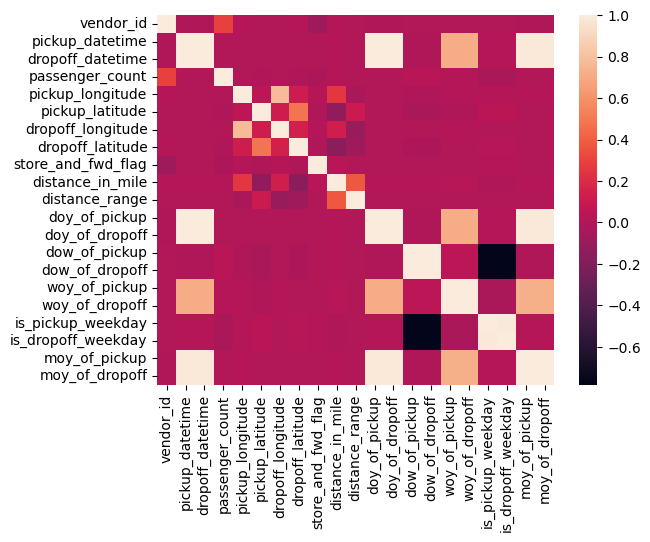

In [128]:
sns.heatmap(X_c.corr())

In [129]:
X_c.corr().unstack().sort_values(ascending = False)

doy_of_dropoff      dropoff_datetime         1
dropoff_datetime    doy_of_dropoff           1
doy_of_pickup       doy_of_pickup            1
passenger_count     passenger_count          1
pickup_longitude    pickup_longitude         1
                                          ... 
dow_of_pickup       is_dropoff_weekday   -0.78
                    is_pickup_weekday    -0.78
is_pickup_weekday   dow_of_pickup        -0.78
dow_of_dropoff      is_dropoff_weekday   -0.78
is_dropoff_weekday  dow_of_dropoff       -0.78
Length: 441, dtype: float64

In [130]:
y_pred = slr_model_c.predict(test_x_c)

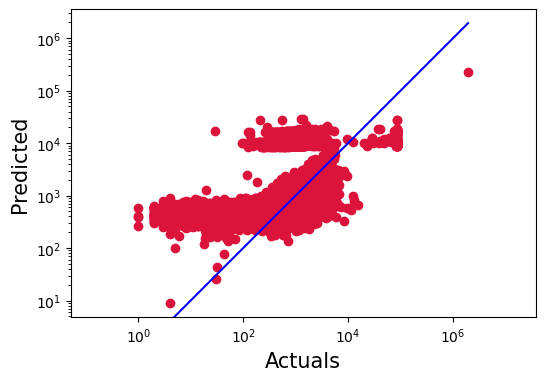

In [131]:
plt.figure(figsize=(6,4))
plt.scatter(test_y_c, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(test_y_c))
p2 = min(min(y_pred), min(test_y_c))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actuals', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()

### 5. Method 2: Linear Regression using KFold CV and Check assumptions  

For loop to store several different values from the split iterations.  The most important for the rest of this analysis is the `residuals` list to be used a few more times in validating assumptions about the model.

Print out and plot the different splits, how each fold uses different indexes for the validation set using below steps:
<br>**5.1** Create the independent and dependent variables.
<br>**5.2** Set the k-fold parameters mentioned above.
<br>**5.3** Create the linear regression model
<br>**5.4** Create the variable `results_kfold` to store the cross-validation scores for each split
<br>**5.5** Incorporate the `kfold` variable into the `cv` parameter.
<br>**5.6** Obtain the $R^2$ by taking the mean of the cross-validation scores from the regression.

KFold          1
Training Mean Absolute Error    : 498.86
Test Mean Absolute Error        : 497.03
R² for current KFold: 20.60% 
β₁: 22.71

#of observations 121554
KFold          2
Training Mean Absolute Error    : 532.32
Test Mean Absolute Error        : 549.14
R² for current KFold: 13.36% 
β₁: 21.05

#of observations 121554
KFold          3
Training Mean Absolute Error    : 538.20
Test Mean Absolute Error        : 534.50
R² for current KFold: 7.96% 
β₁: 20.68

#of observations 121554
KFold          4
Training Mean Absolute Error    : 533.71
Test Mean Absolute Error        : 528.73
R² for current KFold: 10.78% 
β₁: 24.79
121554
KFold          5
Training Mean Absolute Error    : 533.05
Test Mean Absolute Error        : 546.44
R² for current KFold: 13.14% 
β₁: 21.16
121553
KFold          6
Training Mean Absolute Error    : 539.07
Test Mean Absolute Error        : 525.47
R² for current KFold: 9.60% 
β₁: 20.63
121553

Average R² for KFold: 12.57%
Average Mean Absolute Error for KFold: 530

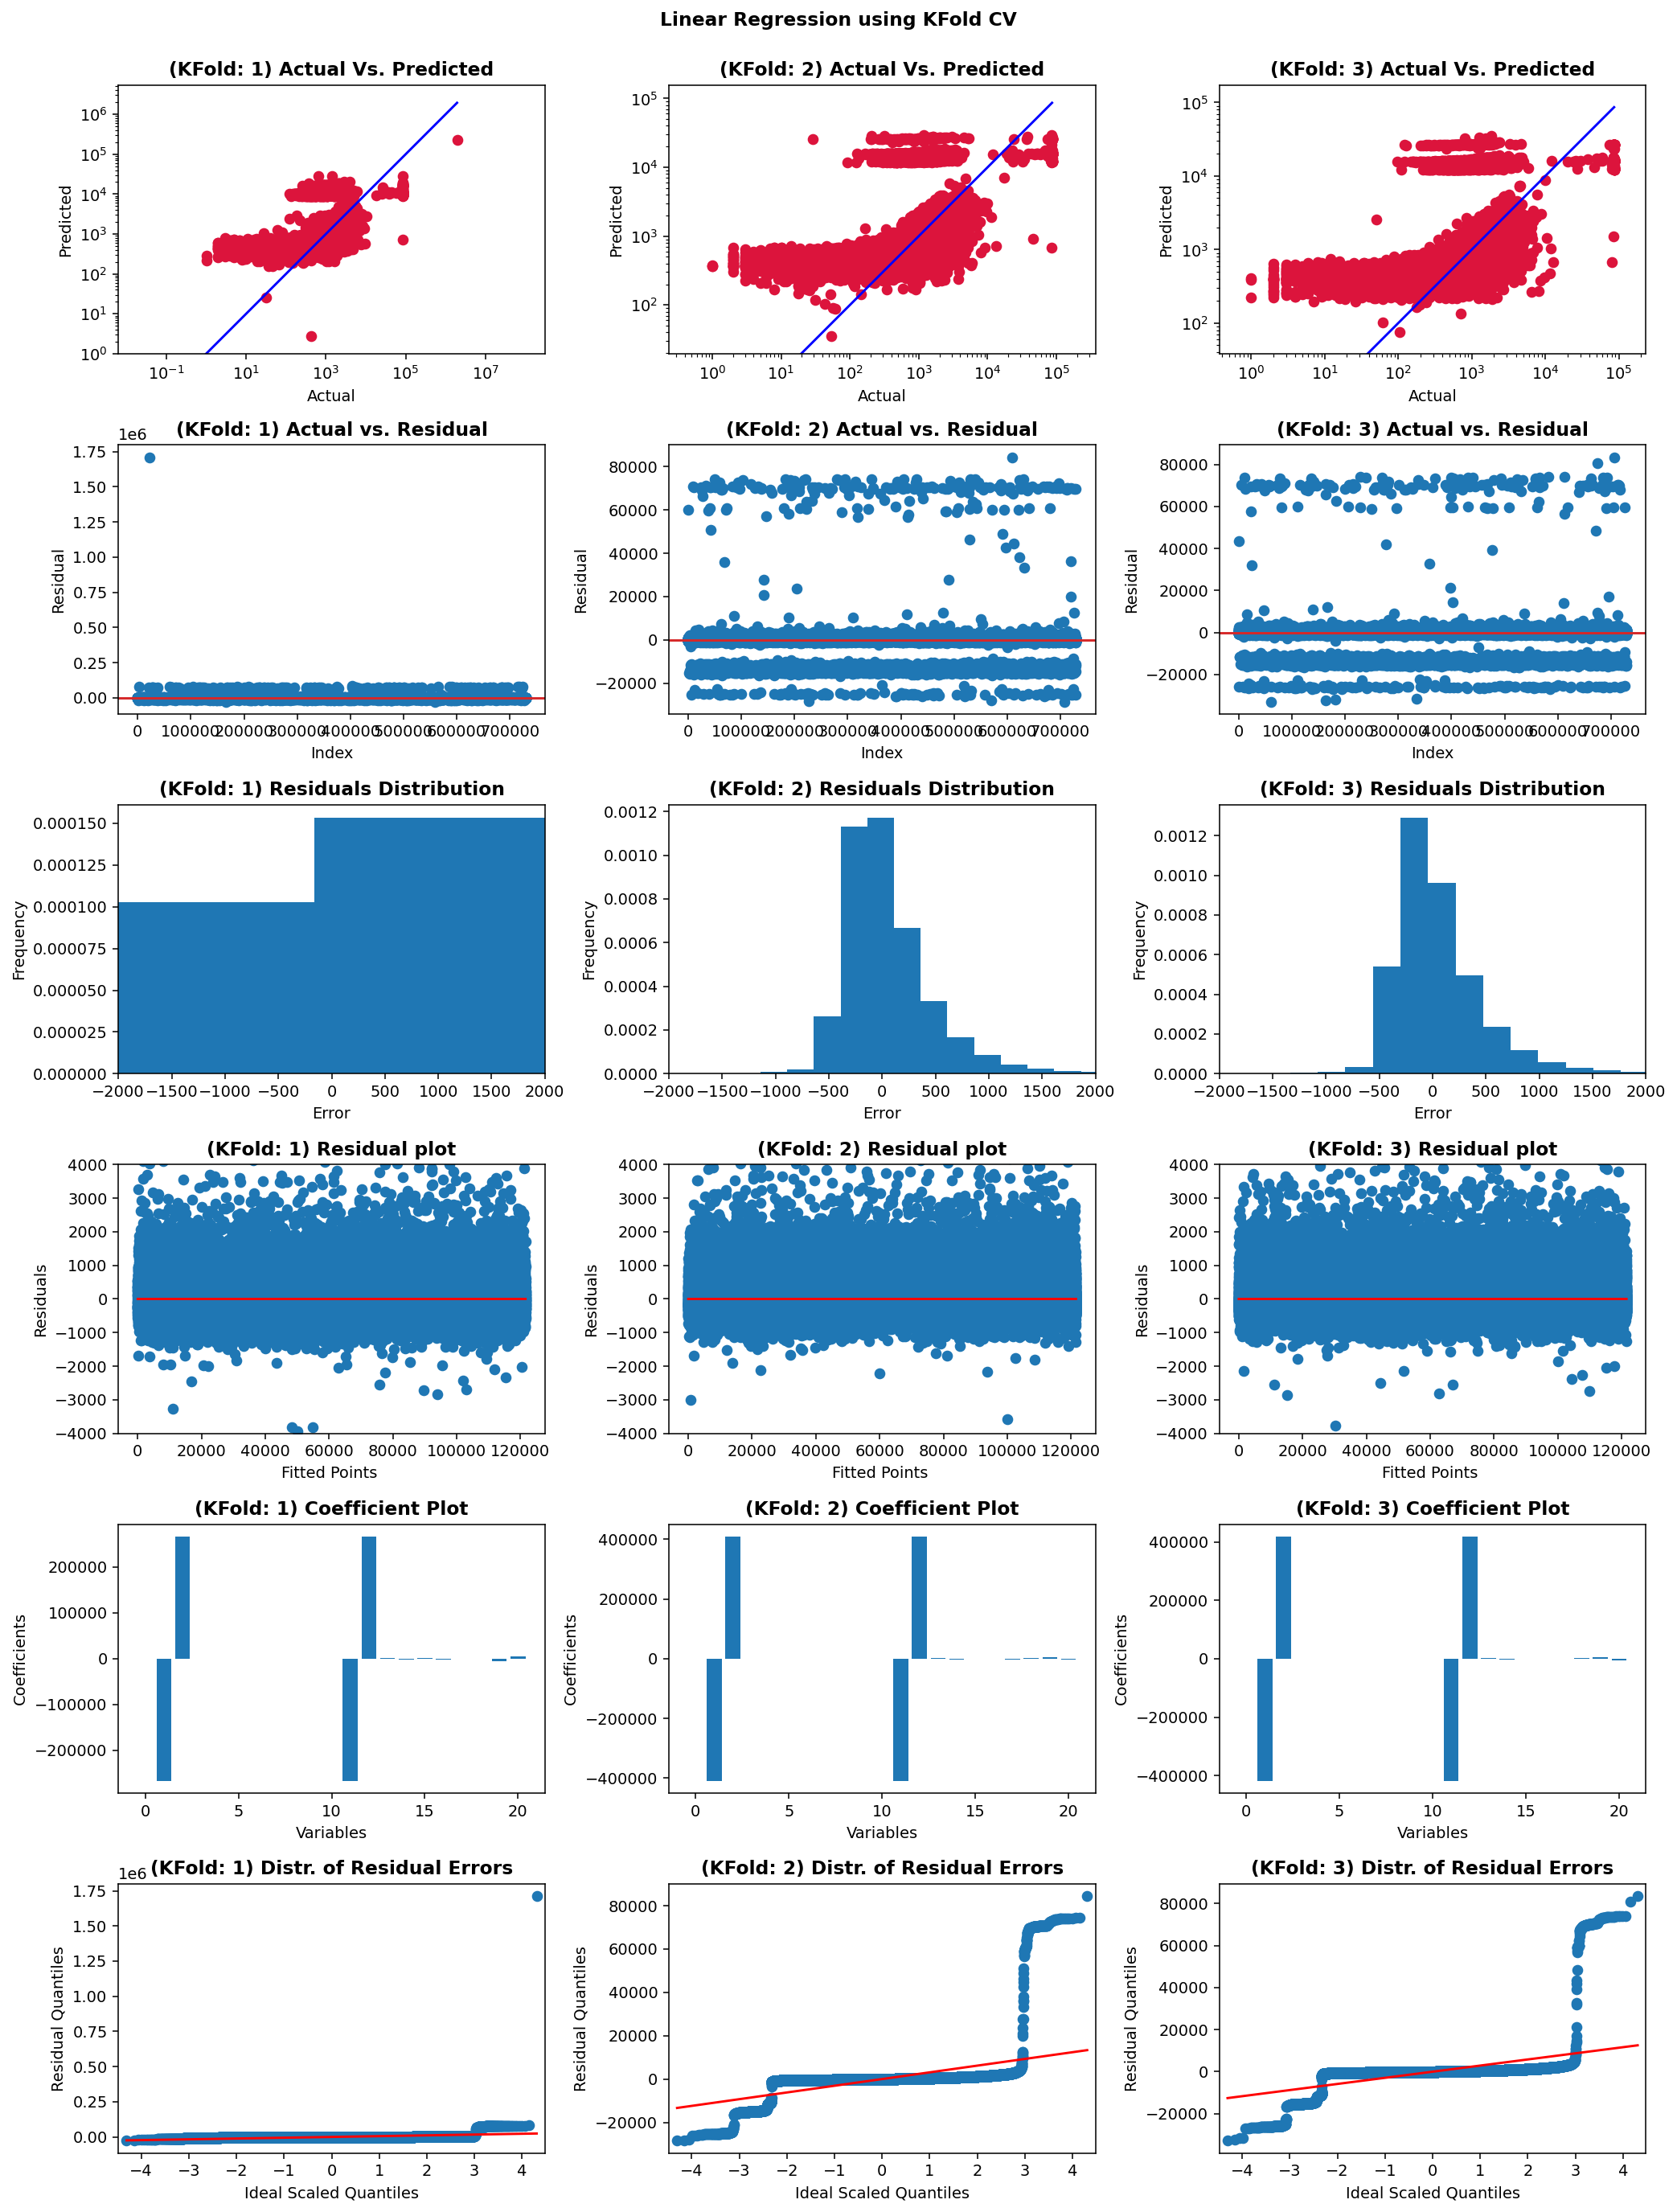

In [33]:
# Initial list parameters

accuracy_model  = []  # The average of this list is the overall R-Squared
mean_aberr      = []
slope           = []
intercept       = []
residuals       = []       # These will be used to validate model assumptions
scores          = []
test_predicts    = np.array([])

# Using k-fold loop to implement linear model and store the parameters

standard_scaler = StandardScaler()
kf = KFold(n_splits=6, shuffle=True, random_state=1) # Set the k-fold parameters
fig, ax = plt.subplots(6, 3, figsize = (15,20), dpi = 140)
fig.suptitle('Linear Regression using KFold CV\n\n', fontweight = 'bold')
j = 0

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print('KFold         ', i+1)
    
    # Split X and y into X and y Train and Test
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Scale the Train and Test variables 
    X_train_scaled   = standard_scaler.fit_transform(X_train)
    X_test_scaled    = standard_scaler.transform(X_test)
    # X_test_saled_df  = pd.DataFrame(X_test_scaled, columns = X.columns)

    # Train the model on the training fold using scaled variables
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Predicting over the Train Set and calculating error
    train_predict = model.predict(X_train_scaled)
    k = mae(y_train, train_predict)
    print("Training Mean Absolute Error    : %.2f" % (k))

    # Predicting over the Test Set and calculating error
    y_predict = model.predict(X_test_scaled)
    residual = y_test - y_predict
    k = mae(y_test, y_predict)
    print("Test Mean Absolute Error        : %.2f" % (k))
    mean_aberr.append(k)
    
    # Arranging and calculating the Residuals
    residuals_df = pd.DataFrame({
        'fitted values' : y_test,
        'predicted values' : y_predict,
        'residual': residual})


    test_predicts = np.append(y_predict, y_predict)
    r2 = r2_score(y_test, y_predict)
    
    scores.append(r2)
    slope.append(model.coef_)
    intercept.append(model.intercept_)
    residuals.append(residual)
    
    print("R\N{SUPERSCRIPT TWO} for current KFold: %.2f%% " % (r2*100.0))
    print('\u03B2\N{SUBSCRIPT ONE}: %.2f' % ((sum(model.coef_)/len(model.coef_))))
    
    if i < 3:
        
        #Plot Actual Vs Predicted
        ax[0, i].scatter(y_test, y_predict, c='crimson')
        ax[0, i].set_yscale('log')
        ax[0, i].set_xscale('log')

        p1 = max(max(y_predict), max(y_test))
        p2 = min(min(y_predict), min(y_test))
        ax[0, i].plot([p1, p2], [p1, p2], 'b-')
        ax[0, i].set_xlabel('Actual')
        ax[0, i].set_ylabel('Predicted')
        ax[0, i].axis('equal')
        ax[0, i].set_title("(KFold: " + str(i+1) +  ") Actual Vs. Predicted", fontweight = 'bold')
        
        #Plot Actual Vs. Residual
        ax[1, i].scatter(y_test.index, residual)
        ax[1, i].set_xlabel('Index')
        ax[1, i].set_ylabel('Residual')
        ax[1, i].set_title("(KFold: " + str(i+1) + ") Actual vs. Residual", fontweight = 'bold')
        ax[1, i].axhline(0, color="#d62728")
        
        ax[2, i].hist(residuals_df['residual'], density = True, bins = 450)
        ax[2, i].set_xlim(-2000, 2000)
        ax[2, i].set_title("(KFold: " + str(i+1) +  ") Residuals Distribution", fontweight = 'bold')
        ax[2, i].set_ylabel("Frequency")
        ax[2, i].set_xlabel("Error")

        print('\n#of observations', residual.shape[0])
        c = residual.shape
        f = range(0,121554)
        k = [0 for i in f]
        ax[3, i].scatter(f, residual[:], label = 'residuals')
        ax[3, i].plot( f, k , color = 'red', label = 'regression line' )
        ax[3, i].set_xlabel('Fitted Points ')
        ax[3, i].set_ylabel('Residuals')
        ax[3, i].set_title("(KFold: " + str(i+1) + ") Residual plot", fontweight = 'bold')
        ax[3, i].set_ylim(-4000, 4000)
        
        x = range(len(X.columns))
        y = model.coef_
        ax[4, i].bar( x, y )
        ax[4, i].set_xlabel( "Variables")
        ax[4, i].set_ylabel('Coefficients')
        ax[4, i].set_title("(KFold: " + str(i+1) + ") Coefficient Plot", fontweight = 'bold')   

        ## Plotting the QQ plot
        qqplot(residual[:], line = 's' , ax = ax[5,i])
        ax[5, i].set_ylabel('Residual Quantiles')
        ax[5, i].set_xlabel('Ideal Scaled Quantiles')
        ax[5, i].set_title("(KFold: " + str(i+1) + ") Distr. of Residual Errors", fontweight = 'bold')   
    else:
        print(residual.shape[0])
            
        plt.tight_layout()


# # Calculate the average cross-validation score
average_score = np.mean(scores)

# Print the average cross-validation score
print("\nAverage R\N{SUPERSCRIPT TWO} for KFold: %.2f%%" % (average_score*100.0))
print("Average Mean Absolute Error for KFold: %.2f" % (np.mean(mean_aberr)))


### 5.7 Parameters of Linear Regression

In [34]:
Coefficients = pd.DataFrame({
    'Variable'    : X.columns,
    'coefficient' : model.coef_
})
Coefficients.shape

(21, 2)

In [35]:
Coefficients.head()

,Variable,coefficient
0,vendor_id,84.087340
1,pickup_datetime,-415624.064746
2,dropoff_datetime,415639.078958
3,passenger_count,10.943889
4,pickup_longitude,1.006874


Text(0.5, -0.05, 'Random sampling led to Split 1 having a very low R² value')

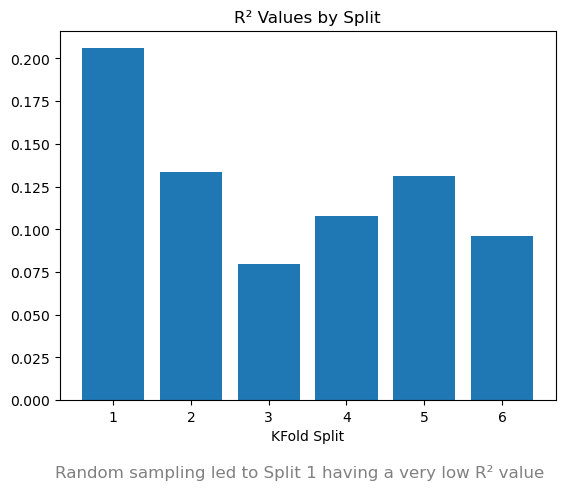

In [36]:
plt.bar(range(1,7), scores)
plt.title("R\N{SUPERSCRIPT TWO} Values by Split")
plt.xlabel("KFold Split")
# plt.ylabel("R\N{SUPERSCRIPT TWO} (Decimal)")
caption="Random sampling led to Split 1 having a very low R\N{SUPERSCRIPT TWO} value"
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=12, color="gray")

In [37]:
# Importing Variance_inflation_Factor funtion from the Statsmodels

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF for every column (only works for the not Catagorical)
VIF = pd.Series([variance_inflation_factor(
    nyc_taxi_trip_df.values, i) for i in range(nyc_taxi_trip_df.shape[1])], index =nyc_taxi_trip_df.columns)
VIF

vendor_id                1.096948
pickup_datetime               inf
dropoff_datetime              inf
passenger_count          1.090627
pickup_longitude         2.738278
pickup_latitude          1.383976
dropoff_longitude        2.671393
dropoff_latitude         1.353994
store_and_fwd_flag       1.007561
trip_duration            1.234902
distance_in_mile         1.359906
distance_range           1.266585
doy_of_pickup                 inf
doy_of_dropoff                inf
dow_of_pickup          150.914362
dow_of_dropoff         151.053541
woy_of_pickup          730.349222
woy_of_dropoff         731.671325
is_pickup_weekday      116.425055
is_dropoff_weekday     116.877524
moy_of_pickup         8310.166987
moy_of_dropoff        8310.399405
dtype: float64

Check below correlation with Target for those variables that are high in VIF.

In [38]:
nyc_taxi_trip_df.corr()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,doy_of_pickup,doy_of_dropoff,dow_of_pickup,dow_of_dropoff,woy_of_pickup,woy_of_dropoff,is_pickup_weekday,is_dropoff_weekday,moy_of_pickup,moy_of_dropoff
vendor_id,1.000000,-0.005227,-0.005203,0.286463,0.008198,0.002861,0.002371,0.005259,-0.080120,0.027752,...,-0.005227,-0.005203,0.000787,0.000900,-0.001291,-0.001335,-0.002616,-0.002652,-0.005363,-0.005336
pickup_datetime,-0.005227,1.000000,0.999998,-0.001182,0.003737,-0.001244,0.003762,-0.001627,0.000501,0.009418,...,1.000000,0.999998,-0.012497,-0.012225,0.713257,0.713902,0.006542,0.006720,0.985661,0.985660
dropoff_datetime,-0.005203,0.999998,1.000000,-0.001168,0.003764,-0.001313,0.003787,-0.001673,0.000500,0.010285,...,0.999998,1.000000,-0.012473,-0.012163,0.713256,0.713898,0.006538,0.006663,0.985659,0.985661
passenger_count,0.286463,-0.001182,-0.001168,1.000000,0.001163,-0.004696,-0.000027,-0.003944,-0.020898,0.013022,...,-0.001182,-0.001168,0.025758,0.025941,0.005154,0.005114,-0.030144,-0.030362,-0.001481,-0.001497
pickup_longitude,0.008198,0.003737,0.003764,0.001163,1.000000,0.047635,0.780647,0.118473,0.011732,0.035447,...,0.003737,0.003764,-0.016031,-0.016846,0.006579,0.006509,0.011774,0.012366,0.004037,0.004090
pickup_latitude,0.002861,-0.001244,-0.001313,-0.004696,0.047635,1.000000,0.119970,0.479352,-0.009230,-0.038163,...,-0.001244,-0.001313,-0.029073,-0.029254,-0.004786,-0.004787,0.034099,0.034490,-0.000165,-0.000233
dropoff_longitude,0.002371,0.003762,0.003787,-0.000027,0.780647,0.119970,1.000000,0.149598,0.009801,0.020664,...,0.003762,0.003787,-0.001473,-0.001396,0.005541,0.005554,0.001357,0.001233,0.003883,0.003923
dropoff_latitude,0.005259,-0.001627,-0.001673,-0.003944,0.118473,0.479352,0.149598,1.000000,-0.011415,-0.028283,...,-0.001627,-0.001673,-0.022028,-0.022396,-0.002402,-0.002406,0.023510,0.023830,-0.000580,-0.000621
store_and_fwd_flag,-0.080120,0.000501,0.000500,-0.020898,0.011732,-0.009230,0.009801,-0.011415,1.000000,0.002754,...,0.000501,0.000500,-0.001940,-0.001748,0.000580,0.000590,0.004371,0.004123,0.000238,0.000244
trip_duration,0.027752,0.009418,0.010285,0.013022,0.035447,-0.038163,0.020664,-0.028283,0.002754,1.000000,...,0.009418,0.010285,-0.002302,-0.003369,0.007907,0.007072,0.007740,0.007167,0.009378,0.010135


#### Removing features having high VIF and referencing to CORR()

In [39]:
X_vif = X.drop(labels = ['moy_of_pickup', 'moy_of_dropoff', 'woy_of_dropoff', 'woy_of_dropoff', 
                         'is_dropoff_weekday', 'dow_of_dropoff', 'woy_of_pickup'], axis = 1)
X_vif.shape

(729322, 15)

In [40]:
# Calculating VIF after removing highly VIF valued columns
VIF = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])], index = X_vif.columns)
VIF

vendor_id             1.096376
pickup_datetime            inf
dropoff_datetime           inf
passenger_count       1.090547
pickup_longitude      2.737671
pickup_latitude       1.383929
dropoff_longitude     2.670990
dropoff_latitude      1.353954
store_and_fwd_flag    1.007551
distance_in_mile      1.343615
distance_range        1.264332
doy_of_pickup              inf
doy_of_dropoff             inf
dow_of_pickup         2.577655
is_pickup_weekday     2.577859
dtype: float64

### 5.8 Re-run Linear Regression (After removing highly correcly variables)

Training Mean Absolute Error    : 500.56
Test Mean Absolute Error        : 501.33
R² after VIF: 19.37% 
β₁: 29.16



Text(0.5, 1.0, 'Actual Vs. Predicted')

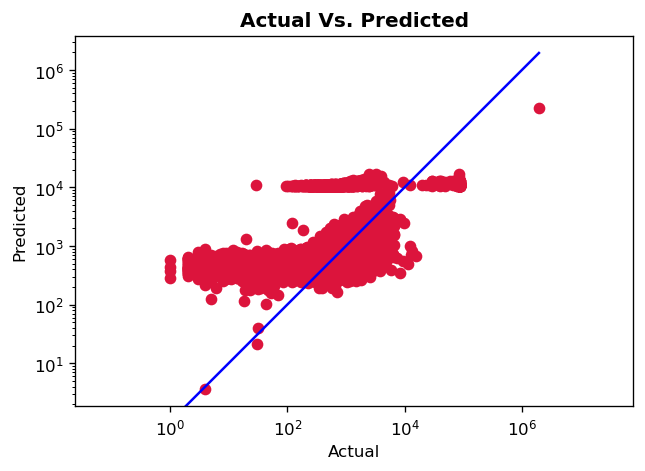

In [41]:
X_vif_c   = X_vif.copy()
y_vif_c   = Y.copy()

train_x_vif_c, test_x_vif_c, train_y_vif_c, test_y_vif_c = train_test_split(X_vif_c, y_vif_c, random_state = 101)

standard_scaler_vif  = StandardScaler()
train_x_vif_c_scaled = standard_scaler_vif.fit_transform(train_x_vif_c)
test_x_vif_c_scaled  = standard_scaler_vif.transform(test_x_vif_c)

# Train the model on the training fold using scaled variables
model = LinearRegression()
model.fit(train_x_vif_c_scaled, train_y_vif_c)

# Predicting over the Train Set and calculating error
train_predict_vif = model.predict(train_x_vif_c_scaled)
k = mae(train_predict_vif, train_y_vif_c)
print("Training Mean Absolute Error    : %.2f" % (k))

# Predicting over the Test Set and calculating error
y_predict_vif = model.predict(test_x_vif_c_scaled)
residual = test_y_vif_c - y_predict_vif
k = mae(y_predict_vif, test_y_vif_c)
print("Test Mean Absolute Error        : %.2f" % (k))

r2 = r2_score(test_y_vif_c, y_predict_vif)
print("R\N{SUPERSCRIPT TWO} after VIF: %.2f%% " % (r2*100.0))
print('\u03B2\N{SUBSCRIPT ONE}: %.2f\n' % ((sum(model.coef_)/len(model.coef_))))


#Plot Actual Vs Predicted
plt.figure(figsize=(6, 4), dpi=120, facecolor='w', edgecolor='b')

plt.scatter(test_y_vif_c, y_predict_vif, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_predict_vif), max(test_y_vif_c))
p2 = min(min(y_predict_vif), min(test_y_vif_c))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')
plt.title("Actual Vs. Predicted", fontweight = 'bold')

In [42]:
Coefficients = pd.DataFrame({
    'Variabla'    : X_vif_c.columns,
    'coefficient' : model.coef_
})
Coefficients.head(25)

,Variabla,coefficient
0,vendor_id,91.119631
1,pickup_datetime,-258182.996111
2,dropoff_datetime,258198.912949
3,passenger_count,15.623659
4,pickup_longitude,12.778024
5,pickup_latitude,-22.882355
6,dropoff_longitude,-19.228395
7,dropoff_latitude,-19.697508
8,store_and_fwd_flag,5.348110
9,distance_in_mile,461.994928


## 6. Method 3: Ridge Regression

### 6.1. Import Libraries

In [43]:
# Importing ridge from sklearn's linear_model module

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### 6.2 Set the different values of alpha to be tested

In [44]:
alpha_ridge = [0, 1e-12, 1e-9, 1e-6, 1e-3, 1e-1, 1, 5, 10, 20]

### 6.3 Create the independent and dependent variables

In [45]:
train_x_ridge, test_x_ridge, train_y_ridge, test_y_ridge = train_test_split(
    X, Y, random_state = 101)

standard_scaler_ridge = StandardScaler()

train_x_ridge_scaled = standard_scaler_ridge.fit_transform(train_x_ridge)
test_x_ridge_scaled = standard_scaler.transform(test_x_ridge)

In [46]:
train_x_ridge.shape, test_x_ridge.shape, train_x_ridge_scaled.shape, test_x_ridge_scaled.shape, \
train_y_ridge.shape, test_y_ridge.shape

((546991, 21), (182331, 21), (546991, 21), (182331, 21), (546991,), (182331,))

In [89]:
#Initialize the dataframe for storing coefficients.
col = ['mrss_train','mrss_test','intercept'] + ['coef_Var_%d'%i for i in range(1,22)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)
coef_matrix_ridge.shape

(10, 24)

In [90]:
#Define the alpha value for which a plot is required:
models_to_plot = {0:231, 1e-4:232, 1e-3:233, 1e-2:234, 1:235, 5:236}

In [116]:
train_x_ridge.shape, test_x_ridge.shape, train_x_ridge_scaled.shape, test_x_ridge_scaled.shape, \
train_y_ridge.shape, test_y_ridge.shape

((546991, 21), (182331, 21), (546991, 21), (182331, 21), (546991,), (182331,))

### 6.3 Create Ridge Regression and fit the model

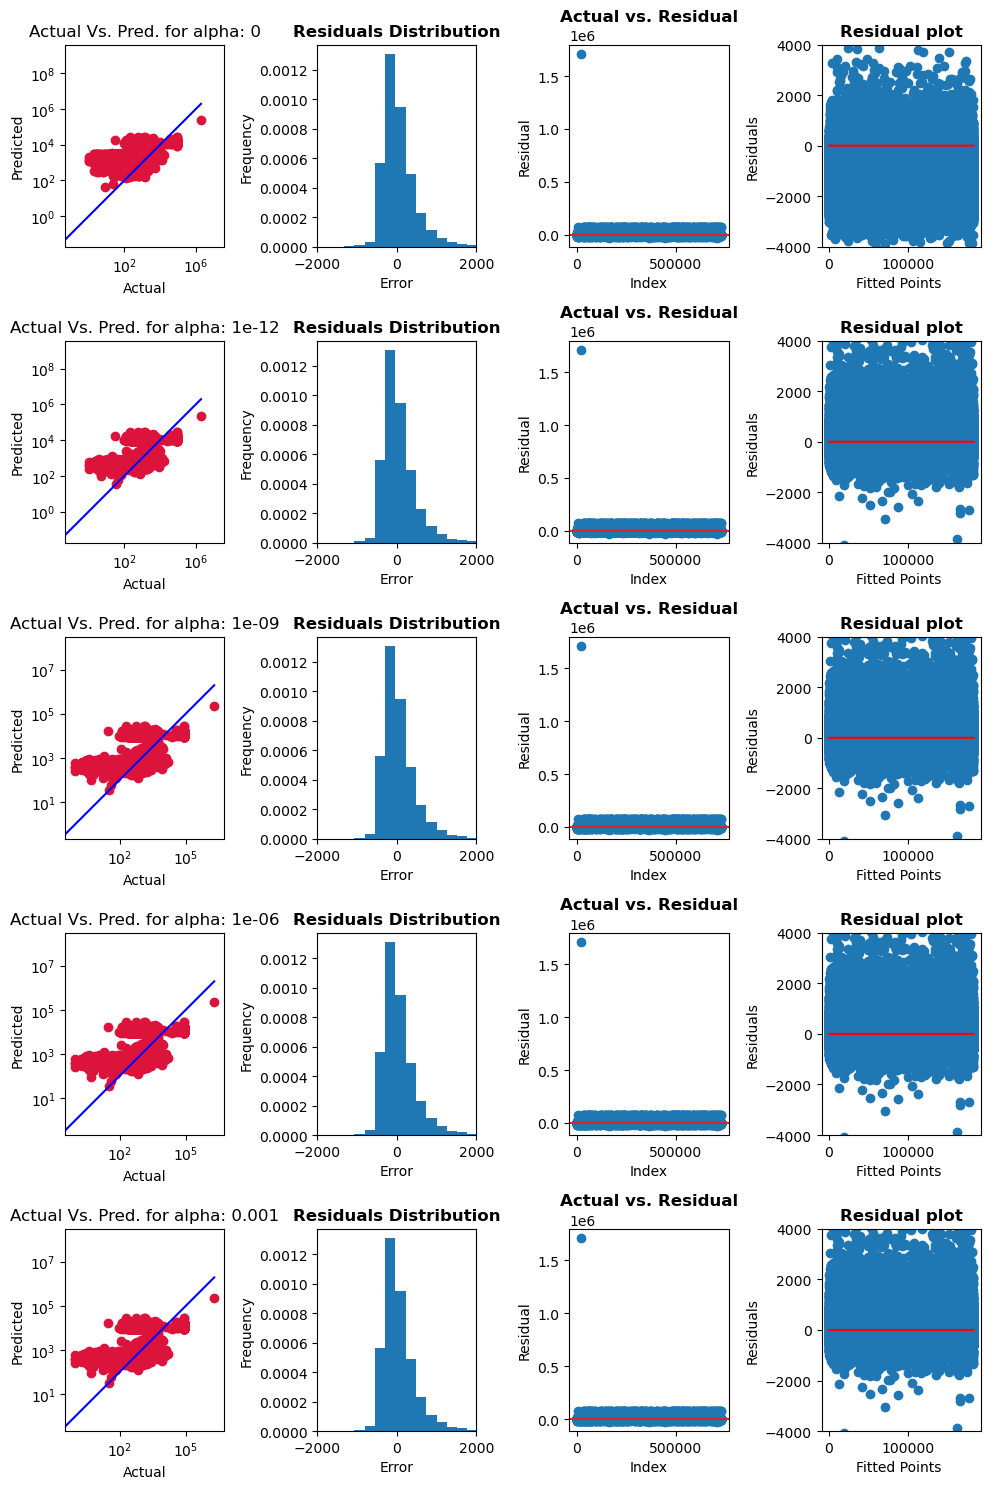

In [92]:
#Iterate over the 10 alpha values:

fig, ax = plt.subplots(5, 4, figsize=(10, 15))
size = test_y_ridge.shape[0]

i = -1
for row in range(5):
    for col in range(1):
        i +=1
        if i >= 10:
            break
        #Fit the model
        n = alpha_ridge[i]
        ridgereg = Ridge(alpha=alpha_ridge[i])
        ridgereg.fit(train_x_ridge_scaled,train_y_ridge)
        train_y_pred = ridgereg.predict(train_x_ridge_scaled)
        test_y_pred  = ridgereg.predict(test_x_ridge_scaled)
        residual     = test_y_ridge - test_y_pred

        #Check if a plot is to be made for the entered alpha
        
        #if alpha in models_to_plot:
        ax[row, col].scatter(test_y_ridge, test_y_pred, c='crimson')
        ax[row, col].set_yscale('log')
        ax[row, col].set_xscale('log')
        ax[row, col].set_title('Actual Vs. Pred. for alpha: %.3g'%alpha_ridge[i])
        p1 = max(max(test_y_pred), max(test_y_ridge))
        p2 = min(min(test_y_pred), min(test_y_ridge))
        ax[row, col].plot([p1, p2], [p1, p2], 'b-')
        ax[row, col].set_xlabel('Actual')
        ax[row, col].set_ylabel('Predicted')
        ax[row, col].axis('equal')
            
        ax[row, col+1].hist(residuals_df['residual'], density = True, bins = 450)
        ax[row, col+1].set_xlim(-2000, 2000)
        ax[row, col+1].set_title("Residuals Distribution", fontweight = 'bold')
        ax[row, col+1].set_ylabel("Frequency")
        ax[row, col+1].set_xlabel("Error")
        
        #Plot Actual Vs. Residual
        ax[row, col+2].scatter(test_y_ridge.index, residual)
        ax[row, col+2].set_xlabel('Index')
        ax[row, col+2].set_ylabel('Residual')
        ax[row, col+2].set_title("Actual vs. Residual", fontweight = 'bold')
        ax[row, col+2].axhline(0, color="#d62728")

        f = range(0,size)
        k = [0 for i in f]
        ax[row, col+3].scatter(f, residual[:], label = 'residuals')
        ax[row, col+3].plot( f, k , color = 'red', label = 'regression line' )
        ax[row, col+3].set_xlabel('Fitted Points ')
        ax[row, col+3].set_ylabel('Residuals')
        ax[row, col+3].set_ylim(-4000, 4000) 
        ax[row, col+3].set_title("Residual plot", fontweight = 'bold')
        
    plt.tight_layout()

    #Return the result in pre-defined format
    mrss_train = sum((train_y_pred - train_y_ridge)**2)/train_x_ridge_scaled.shape[0]
    ret = [mrss_train]

    mrss_test = sum((test_y_pred - test_y_ridge)**2)/test_x_ridge_scaled.shape[0]
    ret.extend([mrss_test])

    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)

In [96]:
#Set the display format to be scientific for ease of analysis

# pd.options.display.float_format = '{:,.2g}'.format
# coef_matrix_ridge

In [97]:
# sns.lineplot(coef_matrix_ridge[['mrss_train','mrss_test']])
# plt.xticks(rotation=90)
# plt.show()

In [98]:
# coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

## Lasso

### 7.1. Import Libraries

In [99]:
#Importing Lasso model from sklearn's linear_model module

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### 7.2 Set the different values of alpha to be tested

In [100]:
#Set the different values of alpha to be tested

alpha_lasso = [0, 1e-12, 1e-9, 1e-6, 1e-3, 1e-1, 1, 5, 10, 20]

### 7.3 Create the independent and dependent variables

In [103]:
train_x_lasso, test_x_lasso, train_y_lasso, test_y_lasso = train_test_split(
    X, Y, random_state = 101)

standard_scaler_lasso = StandardScaler()

train_x_lasso_scaled = standard_scaler_lasso.fit_transform(train_x_lasso)
test_x_lasso_scaled = standard_scaler.transform(test_x_lasso)

In [104]:
train_x_lasso.shape, test_x_lasso.shape, train_x_lasso_scaled.shape, test_x_lasso_scaled.shape, \
train_y_lasso.shape, test_y_lasso.shape

((546991, 21), (182331, 21), (546991, 21), (182331, 21), (546991,), (182331,))

In [105]:
#Initialize a dataframe to store the results:

n = train_x_lasso.shape[1]
print(n)
col = ['mse_train','mse_test','intercept'] + [f'coef_Var_{i}' for i in range(1,n+1)]
ind = [f'alpha {i}' for i in alpha_lasso]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

21


### 7.3 Create Lasso Regression and fit the model

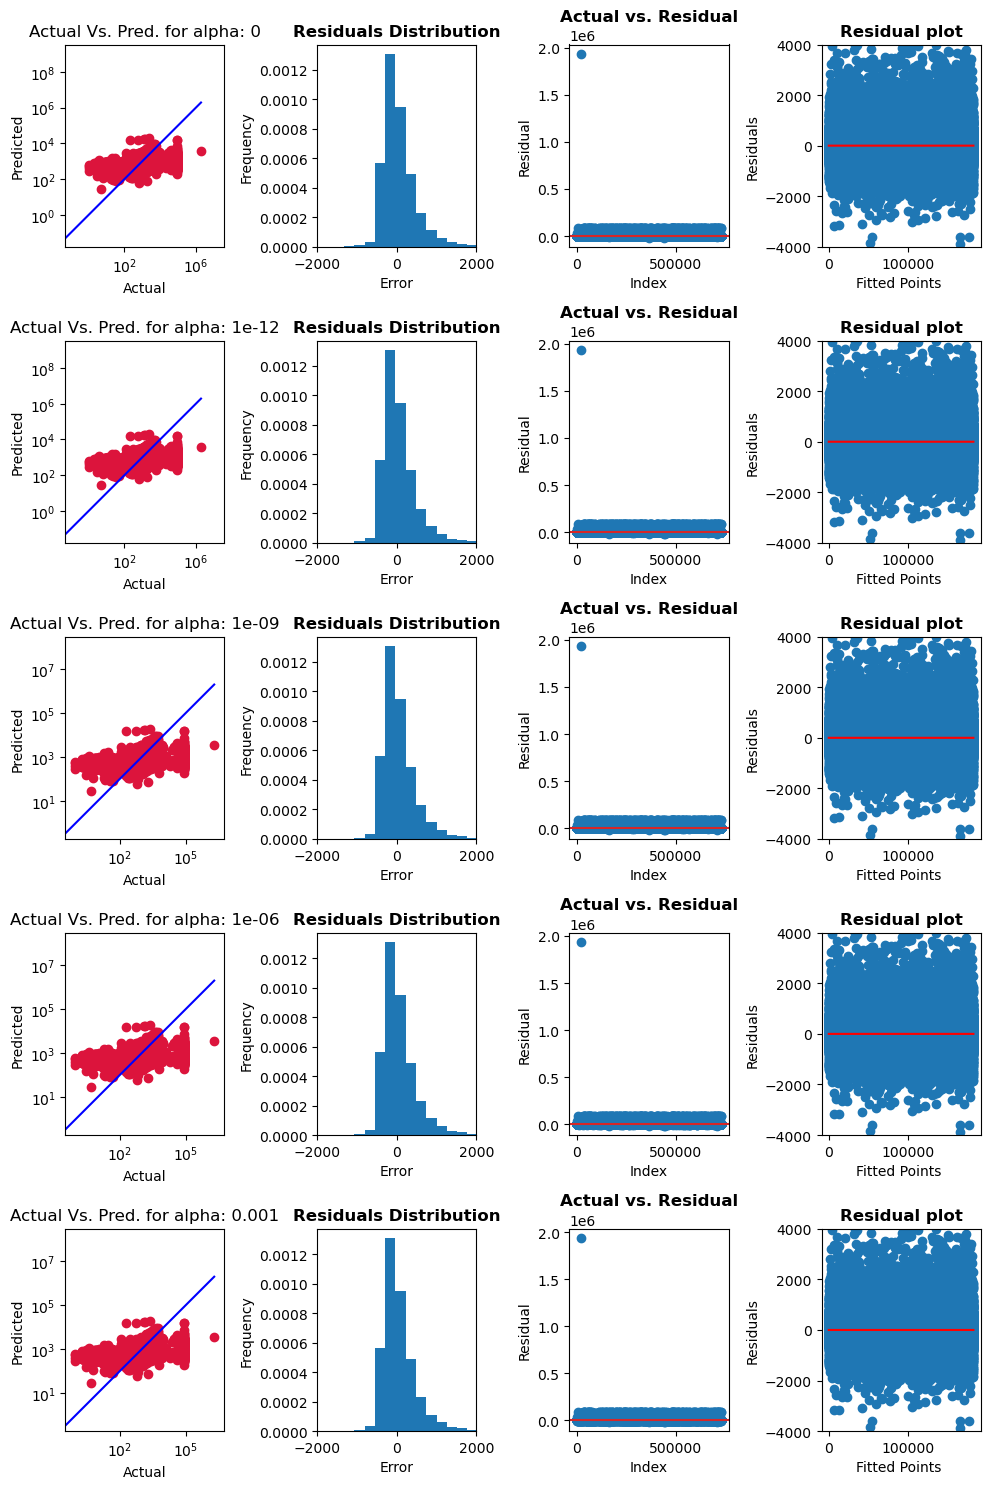

In [111]:
#Iterate over the 10 alpha values:

fig, ax = plt.subplots(5, 4, figsize=(10, 15))
size = test_y_lasso.shape[0]

i = -1
for row in range(5):
    for col in range(1):
        i +=1
        if i >= 10:
            break
        #Fit the model
        n = alpha_lasso[i]
        lasso= Lasso(alpha=alpha_lasso[i])
        lasso.fit(train_x_lasso_scaled,train_y_lasso)
        train_y_pred = lasso.predict(train_x_lasso_scaled)
        test_y_pred  = lasso.predict(test_x_lasso_scaled)
        residual     = test_y_lasso - test_y_pred

        #Check if a plot is to be made for the entered alpha
        
        #if alpha in models_to_plot:
        ax[row, col].scatter(test_y_lasso, test_y_pred, c='crimson')
        ax[row, col].set_yscale('log')
        ax[row, col].set_xscale('log')
        ax[row, col].set_title('Actual Vs. Pred. for alpha: %.3g'%alpha_lasso[i])
        p1 = max(max(test_y_pred), max(test_y_lasso))
        p2 = min(min(test_y_pred), min(test_y_lasso))
        ax[row, col].plot([p1, p2], [p1, p2], 'b-')
        ax[row, col].set_xlabel('Actual')
        ax[row, col].set_ylabel('Predicted')
        ax[row, col].axis('equal')
            
        ax[row, col+1].hist(residuals_df['residual'], density = True, bins = 450)
        ax[row, col+1].set_xlim(-2000, 2000)
        ax[row, col+1].set_title("Residuals Distribution", fontweight = 'bold')
        ax[row, col+1].set_ylabel("Frequency")
        ax[row, col+1].set_xlabel("Error")
        
        #Plot Actual Vs. Residual
        ax[row, col+2].scatter(test_y_lasso.index, residual)
        ax[row, col+2].set_xlabel('Index')
        ax[row, col+2].set_ylabel('Residual')
        ax[row, col+2].set_title("Actual vs. Residual", fontweight = 'bold')
        ax[row, col+2].axhline(0, color="#d62728")

        f = range(0,size)
        k = [0 for i in f]
        ax[row, col+3].scatter(f, residual[:], label = 'residuals')
        ax[row, col+3].plot( f, k , color = 'red', label = 'regression line' )
        ax[row, col+3].set_xlabel('Fitted Points ')
        ax[row, col+3].set_ylabel('Residuals')
        ax[row, col+3].set_ylim(-4000, 4000) 
        ax[row, col+3].set_title("Residual plot", fontweight = 'bold')
        
    plt.tight_layout()

    #Return the result in pre-defined format
    mrss_train = sum((train_y_pred - train_y_lasso)**2)/train_x_lasso_scaled.shape[0]
    ret = [mrss_train]

    mrss_test = sum((test_y_pred - test_y_lasso)**2)/test_x_lasso_scaled.shape[0]
    ret.extend([mrss_test])

    ret.extend([lasso.intercept_])
    ret.extend(lasso.coef_)

In [118]:
#Set the display format to be scientific for ease of analysis

# pd.options.display.float_format = '{:,.2g}'.format
# coef_matrix_lasso

In [119]:
# sns.lineplot(coef_matrix_lasso[['mse_train','mse_test']])
# plt.xticks(rotation=90)
# plt.show()

In [120]:
# coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)